# Week 6- DATA5000: Convolutional Neural Networks: Theory and Implementation

## Objectives

This tutorial provides a comprehensive introduction to Convolutional Neural Networks (CNNs) from both theoretical and practical perspectives. Students will learn:

1. Mathematical foundations of convolution operations
2. CNN architecture components and design principles
3. Implementation of CNN layers from first principles
4. Practical application using TensorFlow/Keras framework
5. Performance evaluation and optimization techniques



In [ ]:
#!pip install tensorflow

In [ ]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.test.is_gpu_available()}")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow version: 2.19.0
GPU available: False


## 1. Mathematical Foundations

### 1.1 Convolution Operation

The convolution operation is mathematically defined as:

$(f * g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau$

For discrete 2D convolution used in image processing:

$(I * K)(i,j) = \sum_m \sum_n I(m,n) K(i-m, j-n)$

Where:
- $I$ is the input feature map
- $K$ is the convolution kernel (filter)
- $(i,j)$ represents spatial coordinates

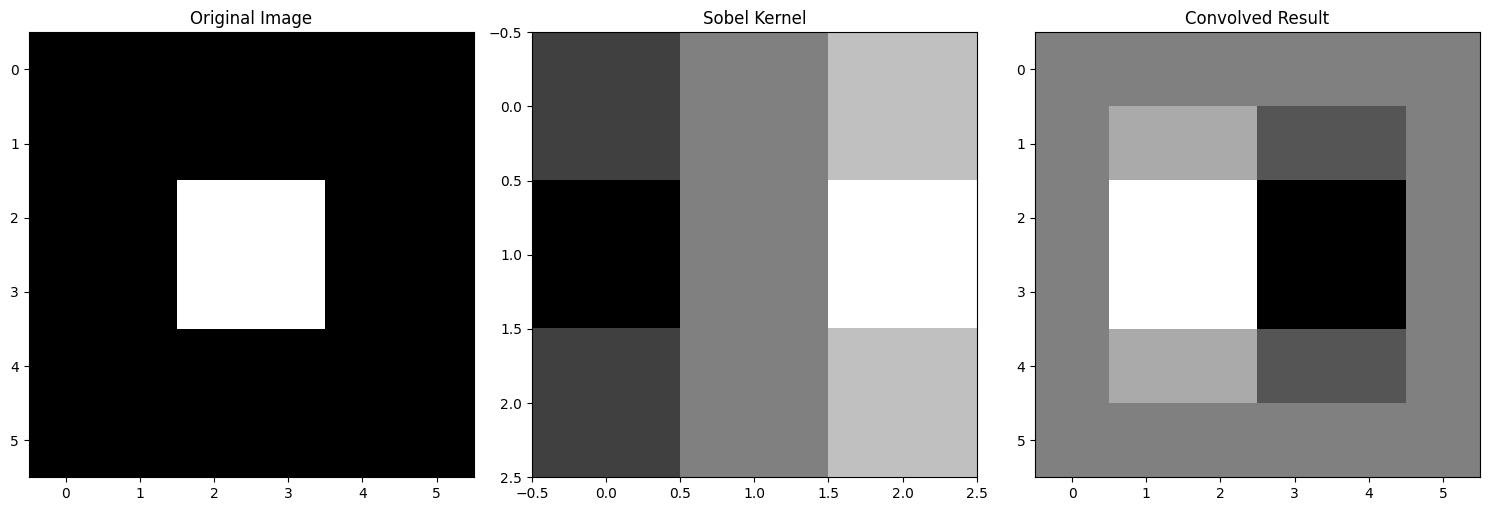

In [ ]:
def convolution_2d(input_matrix, kernel, stride=1, padding=0):
    """
    Implement 2D convolution operation from first principles.

    Args:
        input_matrix: Input feature map (H x W)
        kernel: Convolution kernel (K_h x K_w)
        stride: Stride length for convolution
        padding: Zero-padding amount

    Returns:
        output: Convolved feature map
    """
    # Apply padding
    if padding > 0:
        input_matrix = np.pad(input_matrix, padding, mode='constant', constant_values=0)

    input_h, input_w = input_matrix.shape
    kernel_h, kernel_w = kernel.shape

    # Calculate output dimensions
    output_h = (input_h - kernel_h) // stride + 1
    output_w = (input_w - kernel_w) // stride + 1

    output = np.zeros((output_h, output_w))

    # Perform convolution
    for i in range(0, output_h):
        for j in range(0, output_w):
            # Extract receptive field
            receptive_field = input_matrix[i*stride:i*stride+kernel_h,
                                        j*stride:j*stride+kernel_w]
            # Element-wise multiplication and summation
            output[i, j] = np.sum(receptive_field * kernel)

    return output

# Demonstration with edge detection kernel
sample_image = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 255, 255, 0, 0],
    [0, 0, 255, 255, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]
], dtype=np.float32)

# Sobel edge detection kernel
sobel_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

convolved_result = convolution_2d(sample_image, sobel_kernel, padding=1)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(sobel_kernel, cmap='gray')
axes[1].set_title('Sobel Kernel')
axes[2].imshow(convolved_result, cmap='gray')
axes[2].set_title('Convolved Result')
plt.tight_layout()
plt.show()

### 1.2 Pooling Operations

Pooling reduces spatial dimensions while preserving important features. Common pooling operations include:

**Max Pooling**: $P_{max}(R) = \max_{(i,j) \in R} x_{i,j}$

**Average Pooling**: $P_{avg}(R) = \frac{1}{|R|} \sum_{(i,j) \in R} x_{i,j}$

Where $R$ represents the pooling region.

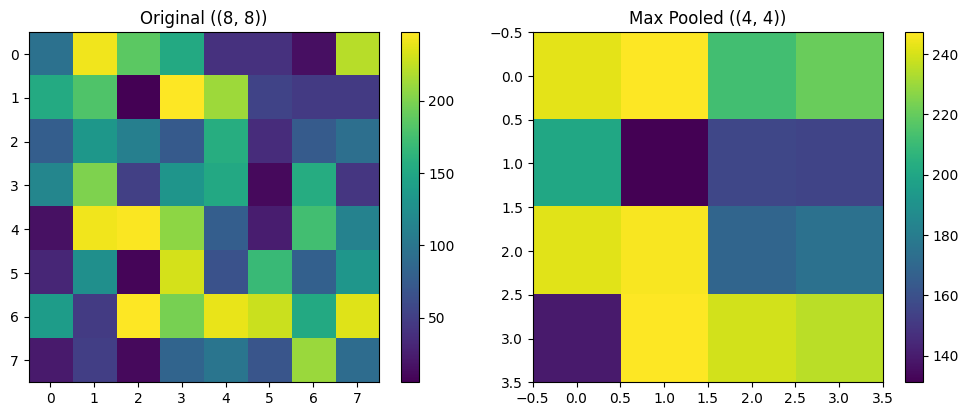

Dimension reduction: (8, 8) → (4, 4)
Parameter reduction factor: 4.0x


In [ ]:
def max_pooling_2d(input_matrix, pool_size=2, stride=2):
    """
    Implement 2D max pooling operation.

    Args:
        input_matrix: Input feature map
        pool_size: Size of pooling window
        stride: Stride for pooling operation

    Returns:
        output: Pooled feature map
    """
    input_h, input_w = input_matrix.shape
    output_h = (input_h - pool_size) // stride + 1
    output_w = (input_w - pool_size) // stride + 1

    output = np.zeros((output_h, output_w))

    for i in range(output_h):
        for j in range(output_w):
            pool_region = input_matrix[i*stride:i*stride+pool_size,
                                     j*stride:j*stride+pool_size]
            output[i, j] = np.max(pool_region)

    return output

# Demonstrate pooling effect
test_matrix = np.random.rand(8, 8) * 255
pooled_result = max_pooling_2d(test_matrix, pool_size=2, stride=2)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im1 = axes[0].imshow(test_matrix, cmap='viridis')
axes[0].set_title(f'Original ({test_matrix.shape})')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(pooled_result, cmap='viridis')
axes[1].set_title(f'Max Pooled ({pooled_result.shape})')
plt.colorbar(im2, ax=axes[1])
plt.tight_layout()
plt.show()

print(f"Dimension reduction: {test_matrix.shape} → {pooled_result.shape}")
print(f"Parameter reduction factor: {test_matrix.size / pooled_result.size:.1f}x")

## 2. CNN Architecture Components

### 2.1 Convolutional Layer

A convolutional layer applies multiple learnable filters to extract features. The output for filter $k$ is:

$y_k = \sigma(W_k * x + b_k)$

Where:
- $W_k$ is the weight kernel for filter $k$
- $b_k$ is the bias term
- $\sigma$ is the activation function
- $*$ denotes convolution operation

Input shape: (28, 28)
Output shape: (4, 26, 26)
Number of parameters: 40


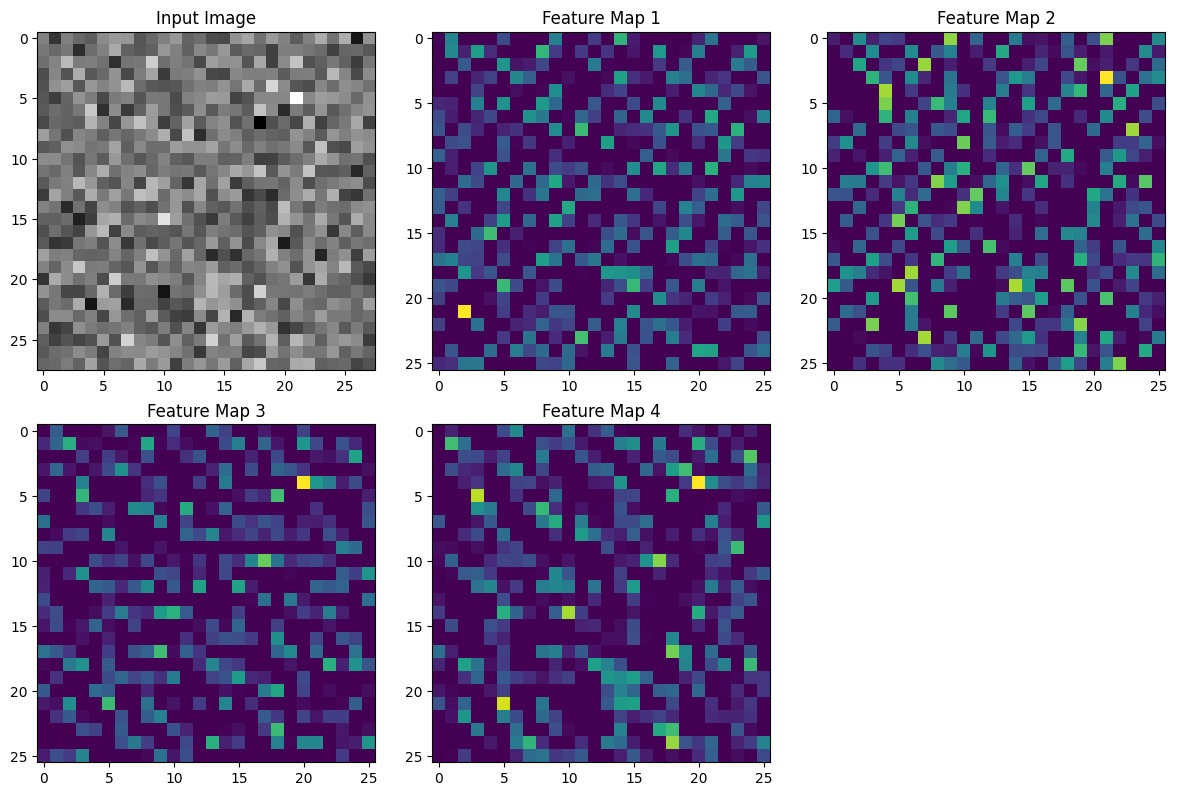

In [ ]:
class ConvolutionalLayer:
    """
    Simple implementation of a convolutional layer for educational purposes.
    """

    def __init__(self, num_filters, filter_size, input_shape):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.input_shape = input_shape

        # Initialize weights using Xavier initialization
        self.weights = np.random.randn(num_filters, filter_size, filter_size) / np.sqrt(filter_size * filter_size)
        self.biases = np.zeros(num_filters)

    def forward(self, input_data):
        """
        Forward pass through convolutional layer.
        """
        self.input_data = input_data
        h, w = input_data.shape
        output_dim = h - self.filter_size + 1

        output = np.zeros((self.num_filters, output_dim, output_dim))

        for f in range(self.num_filters):
            # Convolution for each filter
            conv_result = convolution_2d(input_data, self.weights[f])
            # Add bias and apply ReLU activation
            output[f] = np.maximum(0, conv_result + self.biases[f])

        return output

    def get_parameters(self):
        """
        Return number of learnable parameters.
        """
        weight_params = self.num_filters * self.filter_size * self.filter_size
        bias_params = self.num_filters
        return weight_params + bias_params

# Demonstrate convolutional layer
input_image = np.random.randn(28, 28)
conv_layer = ConvolutionalLayer(num_filters=4, filter_size=3, input_shape=(28, 28))
feature_maps = conv_layer.forward(input_image)

print(f"Input shape: {input_image.shape}")
print(f"Output shape: {feature_maps.shape}")
print(f"Number of parameters: {conv_layer.get_parameters()}")

# Visualize learned feature maps
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes[0, 0].imshow(input_image, cmap='gray')
axes[0, 0].set_title('Input Image')

# Show learned filters
for i in range(4):
    row = (i + 1) // 3
    col = (i + 1) % 3
    if row < 2 and col < 3:
        axes[row, col].imshow(feature_maps[i], cmap='viridis')
        axes[row, col].set_title(f'Feature Map {i+1}')

# Remove empty subplot
axes[1, 2].remove()
plt.tight_layout()
plt.show()

## 3. Complete CNN Implementation

### 3.1 MNIST Digit Classification

We will implement a CNN for handwritten digit recognition using the MNIST dataset. This represents a canonical computer vision task in deep learning.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)
Number of classes: 10
Preprocessed training shape: (60000, 28, 28, 1)
Label shape: (60000, 10)


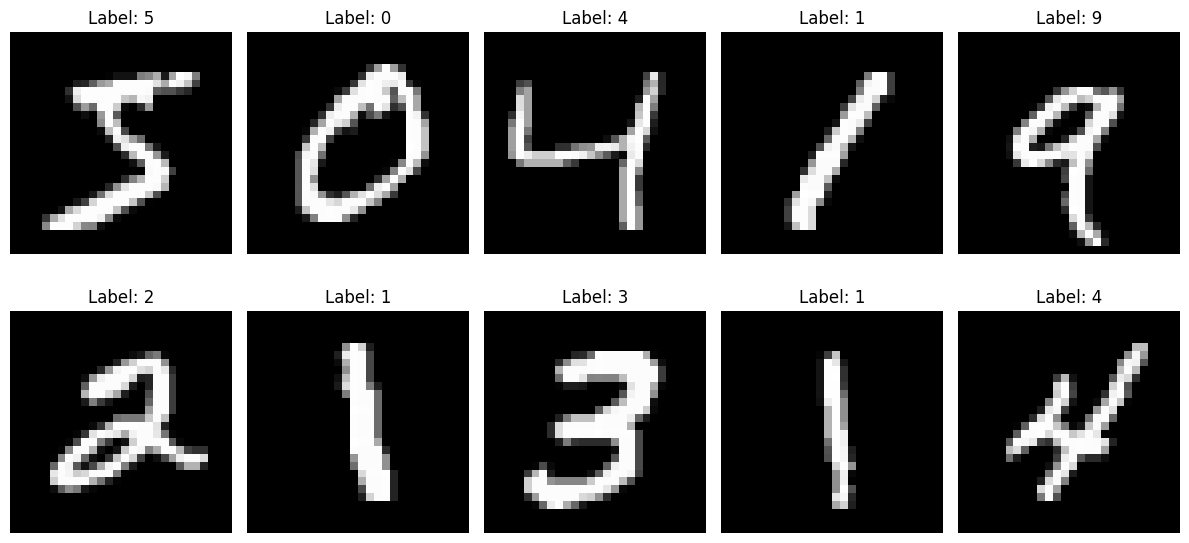

In [ ]:
# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Data preprocessing
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add channel dimension for CNN
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Convert labels to categorical
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(f"Preprocessed training shape: {x_train.shape}")
print(f"Label shape: {y_train.shape}")

# Visualize sample data
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(x_train[i, :, :, 0], cmap='gray')
    axes[row, col].set_title(f'Label: {np.argmax(y_train[i])}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def create_mnist_cnn():
    """
    Create CNN architecture for MNIST classification.

    Architecture follows LeNet-5 principles with modern improvements:
    - Convolutional layers for feature extraction
    - Max pooling for dimension reduction
    - Dropout for regularization
    - Dense layers for classification
    """
    model = keras.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1),
                     name='conv1'),
        layers.BatchNormalization(name='bn1'),
        layers.MaxPooling2D((2, 2), name='pool1'),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
        layers.BatchNormalization(name='bn2'),
        layers.MaxPooling2D((2, 2), name='pool2'),

        # Third convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', name='conv3'),

        # Classification layers
        layers.Flatten(name='flatten'),
        layers.Dense(64, activation='relu', name='fc1'),
        layers.Dropout(0.5, name='dropout'),
        layers.Dense(10, activation='softmax', name='output')
    ])

    return model

# Create and compile model
model = create_mnist_cnn()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

# Calculate parameter counts
trainable_params = model.count_params()
print(f"\nTotal trainable parameters: {trainable_params:,}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 26, 26, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 11, 11, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,706 (366.04 KB)

 Trainable params: 93,514 (365.29 KB)

 Non-trainable params: 192 (768.00 B)


Total trainable parameters: 93,706


In [ ]:
# Train the model
print("Training CNN on MNIST dataset...")

# Define callbacks for training optimization
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2
    )
]

# Train model
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Training CNN on MNIST dataset...
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 65s 154ms/step - accuracy: 0.9806 - loss: 0.0685 - val_accuracy: 0.9912 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 152ms/step - accuracy: 0.9855 - loss: 0.0518 - val_accuracy: 0.9925 - val_loss: 0.0299 - learning_rate: 0.0010
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 149ms/step - accuracy: 0.9873 - loss: 0.0432 - val_accuracy: 0.9887 - val_loss: 0.0495 - learning_rate: 0.0010
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 85s 156ms/step - accuracy: 0.9892 - loss: 0.0380 - val_accuracy: 0.9893 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 155ms/step - accuracy: 0.9918 - loss: 0.0272 - val_accuracy: 0.9930 - val_loss: 0.0312 - learning_rate: 5.0000e-04

Test Accuracy: 0.9929
Test Loss: 0.0305


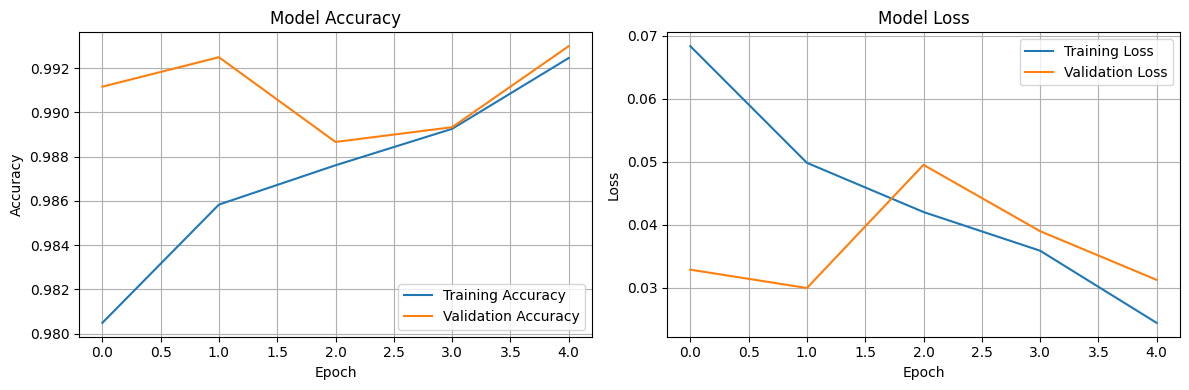

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



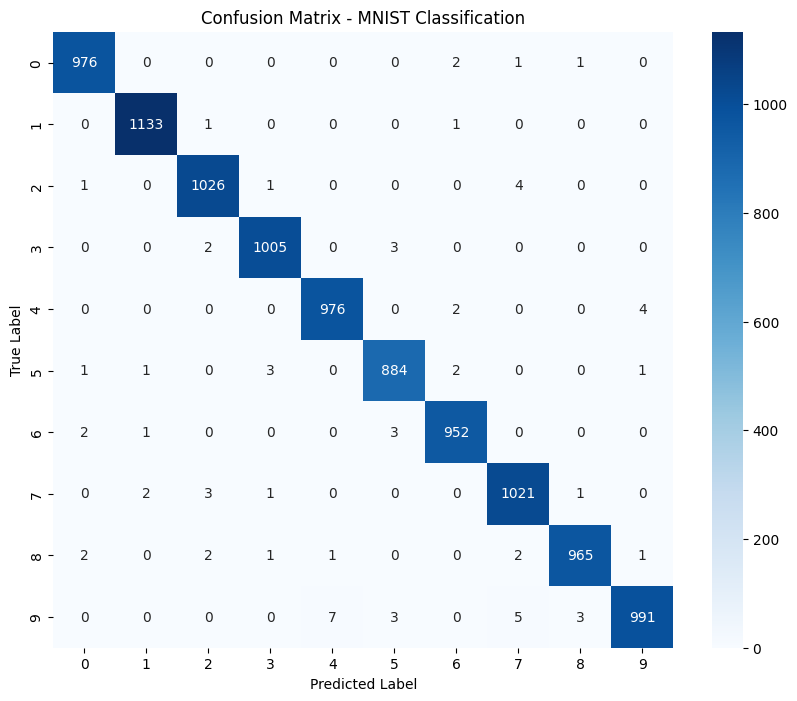

In [ ]:
# Visualize training history
def plot_training_history(history):
    """
    Plot training and validation metrics over epochs.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Generate predictions and analyze performance
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - MNIST Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 4. Advanced CNN: CIFAR-10 Classification

### 4.1 CIFAR-10 Dataset Analysis

CIFAR-10 presents a more challenging classification task with 10 classes of natural images. Unlike MNIST's grayscale digits, CIFAR-10 contains 32×32 color images requiring more sophisticated feature extraction.

Original CIFAR-10 Training set: (50000, 32, 32, 3)
Original CIFAR-10 Test set: (10000, 32, 32, 3)
Sampled CIFAR-10 Training set: (1000, 32, 32, 3)
Sampled CIFAR-10 Test set: (200, 32, 32, 3)
Pixel value range: [0, 255]


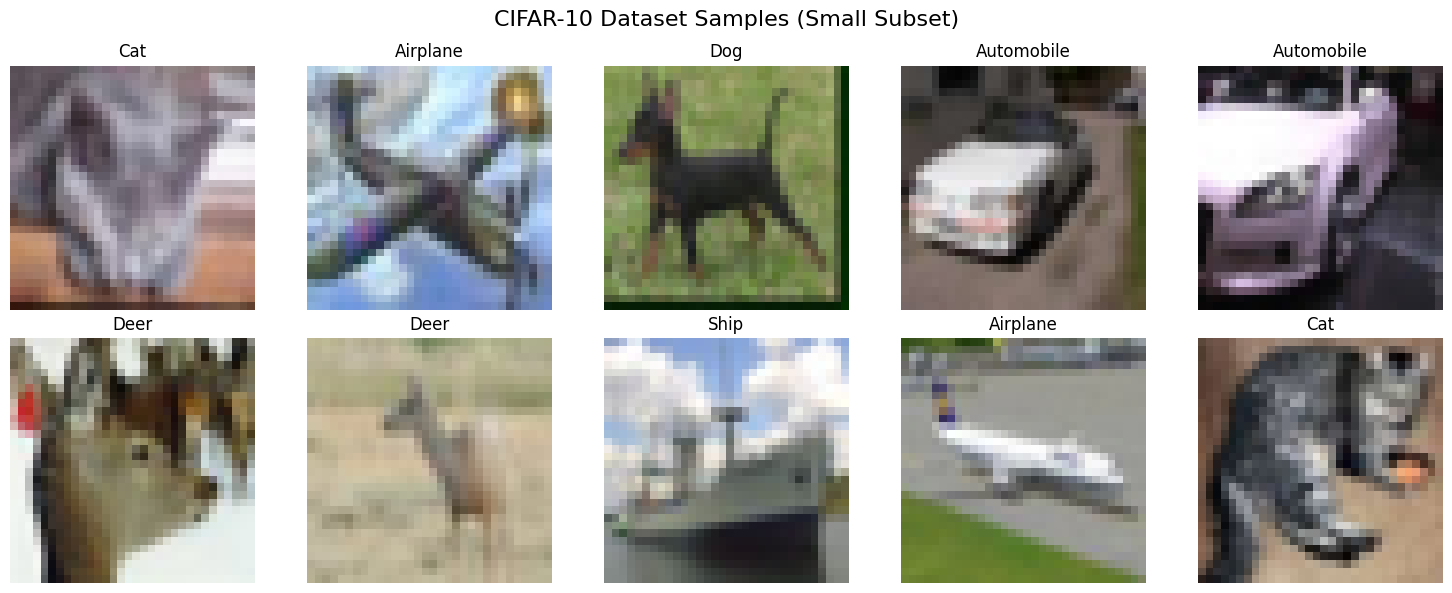

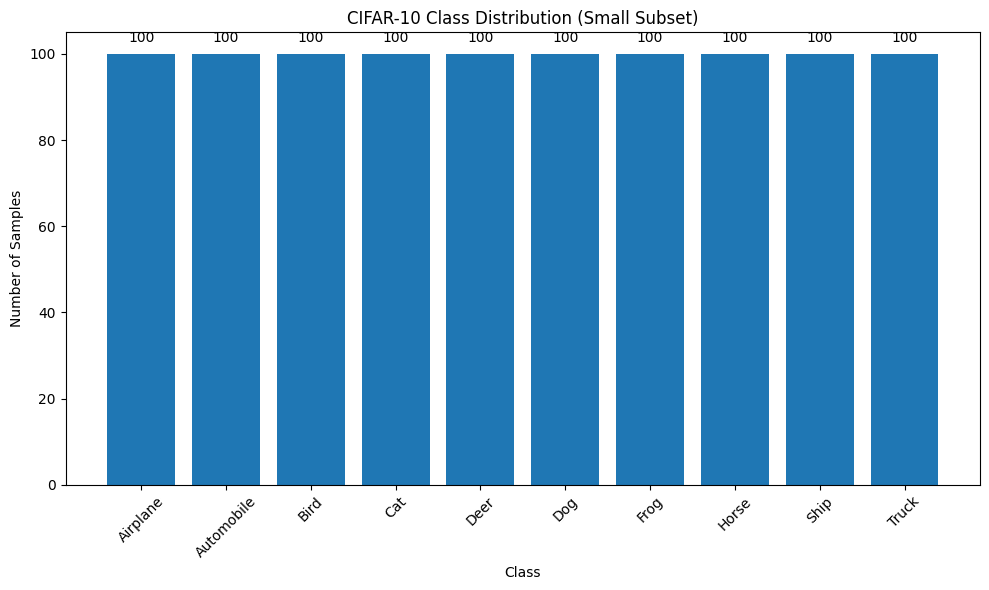


Total training samples: 1000
Total test samples: 200
Samples per class (train): 100
Samples per class (test): 20


In [ ]:
# Load CIFAR-10 dataset
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = keras.datasets.cifar10.load_data()

# Define sample sizes (much smaller)
train_samples_per_class = 100  # 100 samples per class for training
test_samples_per_class = 20    # 20 samples per class for testing

print(f"Original CIFAR-10 Training set: {x_train_cifar.shape}")
print(f"Original CIFAR-10 Test set: {x_test_cifar.shape}")

# Function to sample balanced subset
def sample_balanced_subset(x_data, y_data, samples_per_class):
    """Sample a balanced subset from each class"""
    sampled_x = []
    sampled_y = []

    for class_id in range(10):
        # Find indices for current class
        class_indices = np.where(y_data.flatten() == class_id)[0]

        # Randomly sample from this class
        selected_indices = np.random.choice(
            class_indices,
            size=min(samples_per_class, len(class_indices)),
            replace=False
        )

        # Add to sampled data
        sampled_x.append(x_data[selected_indices])
        sampled_y.append(y_data[selected_indices])

    return np.vstack(sampled_x), np.vstack(sampled_y)

# Sample smaller subsets
x_train_cifar, y_train_cifar = sample_balanced_subset(
    x_train_cifar, y_train_cifar, train_samples_per_class
)
x_test_cifar, y_test_cifar = sample_balanced_subset(
    x_test_cifar, y_test_cifar, test_samples_per_class
)

# Shuffle the datasets
train_indices = np.random.permutation(len(x_train_cifar))
x_train_cifar = x_train_cifar[train_indices]
y_train_cifar = y_train_cifar[train_indices]

test_indices = np.random.permutation(len(x_test_cifar))
x_test_cifar = x_test_cifar[test_indices]
y_test_cifar = y_test_cifar[test_indices]

# Dataset information
print(f"Sampled CIFAR-10 Training set: {x_train_cifar.shape}")
print(f"Sampled CIFAR-10 Test set: {x_test_cifar.shape}")
print(f"Pixel value range: [{x_train_cifar.min()}, {x_train_cifar.max()}]")

# Class names for CIFAR-10
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Data preprocessing
x_train_cifar = x_train_cifar.astype('float32') / 255.0
x_test_cifar = x_test_cifar.astype('float32') / 255.0

y_train_cifar = keras.utils.to_categorical(y_train_cifar, 10)
y_test_cifar = keras.utils.to_categorical(y_test_cifar, 10)

# Visualize CIFAR-10 samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(x_train_cifar[i])
    axes[row, col].set_title(f'{class_names[np.argmax(y_train_cifar[i])]}')
    axes[row, col].axis('off')
plt.suptitle('CIFAR-10 Dataset Samples (Small Subset)', fontsize=16)
plt.tight_layout()
plt.show()

# Analyze class distribution
train_labels = np.argmax(y_train_cifar, axis=1)
class_counts = np.bincount(train_labels)

plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, class_counts)
plt.title('CIFAR-10 Class Distribution (Small Subset)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

print(f"\nTotal training samples: {len(x_train_cifar)}")
print(f"Total test samples: {len(x_test_cifar)}")
print(f"Samples per class (train): {train_samples_per_class}")
print(f"Samples per class (test): {test_samples_per_class}")

In [ ]:
def create_advanced_cnn():
    """
    Create advanced CNN architecture for CIFAR-10 classification.

    Features:
    - Deeper architecture with residual-like connections
    - Batch normalization for training stability
    - Data augmentation integration
    - Dropout for regularization
    """
    model = keras.Sequential([
        # Data augmentation layers
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),

        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Classification head
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    return model

# Create and compile advanced model
advanced_model = create_advanced_cnn()

advanced_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

advanced_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train advanced CNN on CIFAR-10
print("Training advanced CNN on CIFAR-10...")

# Advanced callbacks
advanced_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        'best_cifar_model.h5',
        save_best_only=True,
        monitor='val_accuracy'
    )
]

# Training with reduced epochs for demonstration
cifar_history = advanced_model.fit(
    x_train_cifar, y_train_cifar,
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    callbacks=advanced_callbacks,
    verbose=1
)

# Evaluate on test set
cifar_test_loss, cifar_test_accuracy = advanced_model.evaluate(
    x_test_cifar, y_test_cifar, verbose=0
)

print(f"\nCIFAR-10 Test Accuracy: {cifar_test_accuracy:.4f}")
print(f"CIFAR-10 Test Loss: {cifar_test_loss:.4f}")

Training advanced CNN on CIFAR-10...
Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.1500 - loss: 3.1919

29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 283ms/step - accuracy: 0.1511 - loss: 3.1851 - val_accuracy: 0.0900 - val_loss: 2.3772 - learning_rate: 0.0010
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accuracy: 0.2254 - loss: 2.5006 - val_accuracy: 0.0700 - val_loss: 2.6789 - learning_rate: 0.0010
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.2534 - loss: 2.2512 - val_accuracy: 0.0700 - val_loss: 3.1053 - learning_rate: 0.0010
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.2743 - loss: 2.0377 - val_accuracy: 0.0700 - val_loss: 3.3746 - learning_rate: 0.0010
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.3701 - loss: 1.8065 - val_accuracy: 0.0700 - val_loss: 3.5332 - learning_rate: 2.0000e-04

CIFAR-10 Test Accuracy: 0.1000
CIFAR-10 Test Loss: 2.3664


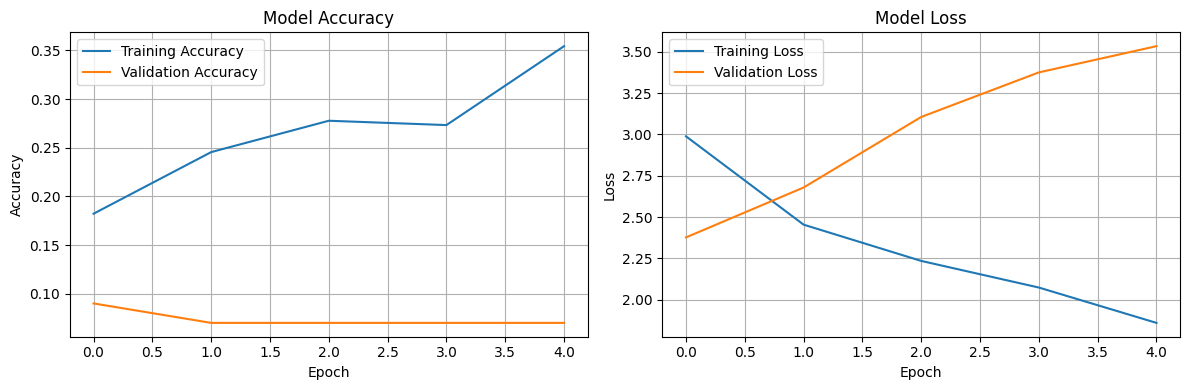

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


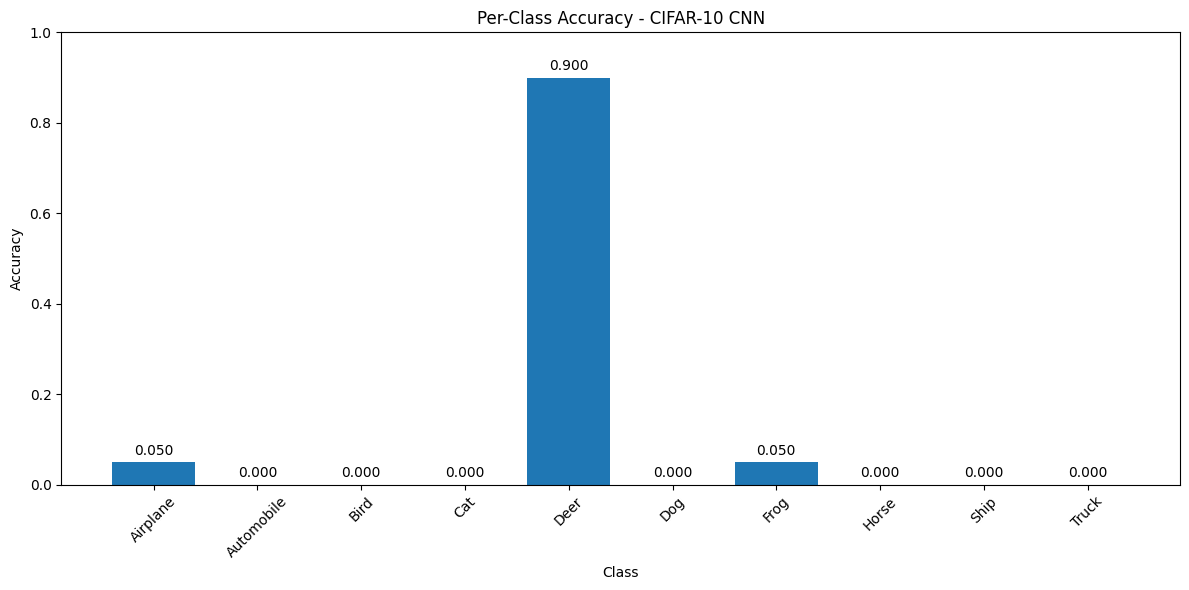


Per-class accuracy summary:
Airplane    : 0.0500
Automobile  : 0.0000
Bird        : 0.0000
Cat         : 0.0000
Deer        : 0.9000
Dog         : 0.0000
Frog        : 0.0500
Horse       : 0.0000
Ship        : 0.0000
Truck       : 0.0000

Mean per-class accuracy: 0.1000
Standard deviation: 0.2674


In [ ]:
# Analyze CIFAR-10 results
plot_training_history(cifar_history)

# Generate predictions for detailed analysis
y_pred_cifar = advanced_model.predict(x_test_cifar)
y_pred_classes_cifar = np.argmax(y_pred_cifar, axis=1)
y_true_classes_cifar = np.argmax(y_test_cifar, axis=1)

# Per-class accuracy analysis
per_class_accuracy = []
for i in range(10):
    class_mask = (y_true_classes_cifar == i)
    class_correct = np.sum((y_pred_classes_cifar[class_mask] == i))
    class_total = np.sum(class_mask)
    class_acc = class_correct / class_total if class_total > 0 else 0
    per_class_accuracy.append(class_acc)

# Visualize per-class accuracy
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, per_class_accuracy)
plt.title('Per-Class Accuracy - CIFAR-10 CNN')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add accuracy values on bars
for bar, acc in zip(bars, per_class_accuracy):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nPer-class accuracy summary:")
for i, (class_name, acc) in enumerate(zip(class_names, per_class_accuracy)):
    print(f"{class_name:12}: {acc:.4f}")

print(f"\nMean per-class accuracy: {np.mean(per_class_accuracy):.4f}")
print(f"Standard deviation: {np.std(per_class_accuracy):.4f}")

## 5. Feature Visualization and Interpretation

### 5.1 Convolutional Layer Activations

Understanding what CNNs learn requires visualization of intermediate feature representations. Each convolutional layer learns increasingly complex patterns from edges to semantic features.

Analyzing image: True label = Airplane, Predicted = Deer


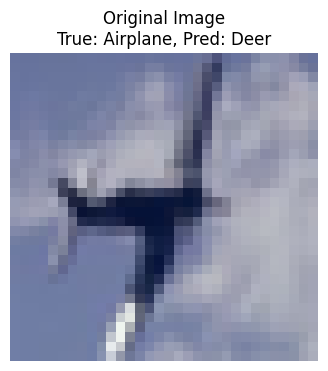

In [ ]:
def visualize_feature_maps(model, input_image, layer_names):
    """
    Visualize activations from specified convolutional layers.

    Args:
        model: Trained CNN model
        input_image: Single input image
        layer_names: List of layer names to visualize
    """
    # Create model that outputs intermediate activations
    layer_outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

    # Get activations
    activations = activation_model.predict(np.expand_dims(input_image, 0))

    # Display results
    fig, axes = plt.subplots(len(layer_names), 8, figsize=(20, 3*len(layer_names)))
    if len(layer_names) == 1:
        axes = axes.reshape(1, -1)

    for layer_idx, (layer_name, activation) in enumerate(zip(layer_names, activations)):
        for i in range(min(8, activation.shape[-1])):
            axes[layer_idx, i].imshow(activation[0, :, :, i], cmap='viridis')
            axes[layer_idx, i].set_title(f'{layer_name} - Filter {i+1}')
            axes[layer_idx, i].axis('off')

    plt.tight_layout()
    plt.show()

# Select a test image from CIFAR-10
test_idx = 0
test_image = x_test_cifar[test_idx]
true_label = class_names[y_true_classes_cifar[test_idx]]
pred_label = class_names[y_pred_classes_cifar[test_idx]]

print(f"Analyzing image: True label = {true_label}, Predicted = {pred_label}")

# Display original image
plt.figure(figsize=(4, 4))
plt.imshow(test_image)
plt.title(f'Original Image\nTrue: {true_label}, Pred: {pred_label}')
plt.axis('off')
plt.show()


### 5.2 Filter Visualization

Examining learned convolutional filters provides insight into the types of patterns the network detects at different hierarchical levels.

Visualizing filters from layer: conv2d_12


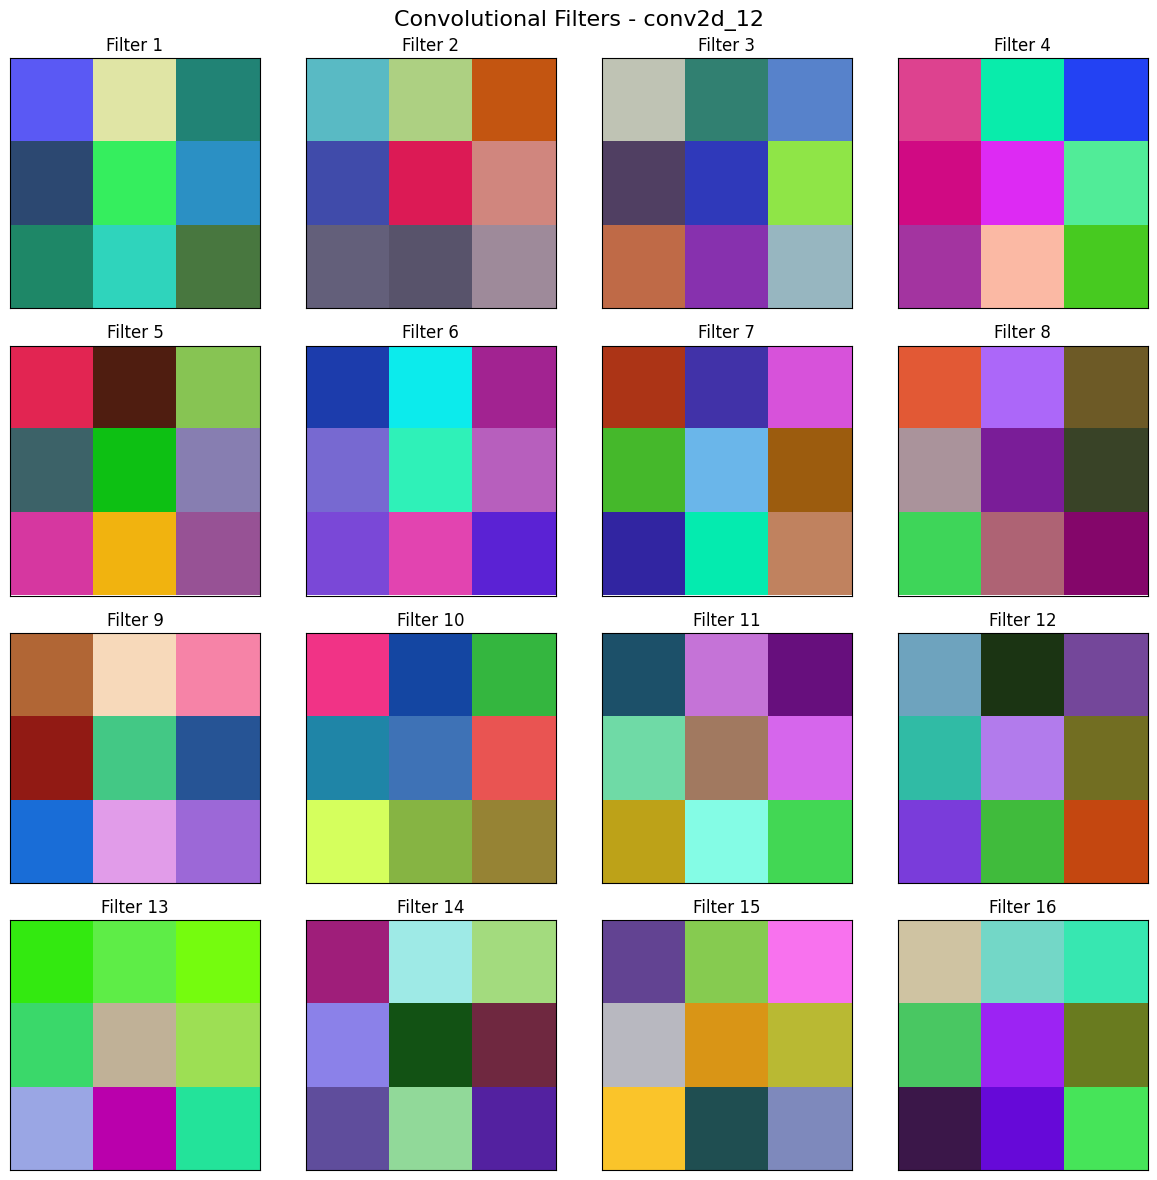

Filter shape: (3, 3, 3, 32)
Number of filters: 32


In [ ]:
def visualize_conv_filters(model, layer_name, num_filters=16):
    """
    Visualize convolutional filters from a specified layer.

    Args:
        model: Trained CNN model
        layer_name: Name of convolutional layer
        num_filters: Number of filters to display
    """
    # Get layer weights
    layer = model.get_layer(layer_name)
    weights = layer.get_weights()[0]  # Shape: (height, width, input_channels, output_channels)

    # Normalize weights for visualization
    weights_min, weights_max = weights.min(), weights.max()
    weights = (weights - weights_min) / (weights_max - weights_min)

    # Calculate grid dimensions
    grid_size = int(np.ceil(np.sqrt(num_filters)))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    fig.suptitle(f'Convolutional Filters - {layer_name}', fontsize=16)

    for i in range(grid_size * grid_size):
        row = i // grid_size
        col = i % grid_size

        if i < num_filters and i < weights.shape[-1]:
            # Handle different input channel dimensions
            if weights.shape[2] == 1:  # Grayscale input
                filter_img = weights[:, :, 0, i]
                axes[row, col].imshow(filter_img, cmap='viridis')
            elif weights.shape[2] == 3:  # RGB input
                filter_img = weights[:, :, :, i]
                axes[row, col].imshow(filter_img)
            else:  # Multi-channel feature maps
                # Show first channel
                filter_img = weights[:, :, 0, i]
                axes[row, col].imshow(filter_img, cmap='viridis')

            axes[row, col].set_title(f'Filter {i+1}')
        else:
            axes[row, col].axis('off')

        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

    plt.tight_layout()
    plt.show()

    print(f"Filter shape: {weights.shape}")
    print(f"Number of filters: {weights.shape[-1]}")

# Visualize filters from first convolutional layer
first_conv_layer = None
for layer in advanced_model.layers:
    if 'conv' in layer.name.lower() and hasattr(layer, 'filters'):
        first_conv_layer = layer.name
        break

if first_conv_layer:
    print(f"Visualizing filters from layer: {first_conv_layer}")
    visualize_conv_filters(advanced_model, first_conv_layer, num_filters=16)
else:
    print("No convolutional layers found for filter visualization")